### Gradual annual mean temperature increase in Steamboat Springs, Colorado 1908 to 2024

I selected Steamboat Springs, Colorado for my analysis because I like to visit there whenever possible, and this becomes a virtual visit.

The current collection of temperature data for station USC0005084 is via Max-Min Thermometers daily at 1700 Lat: 39.9928° N Lon: 105.2668° W.  The data in the entire dataset is from the same general area with some minor precise latitude/longitude and elevation variations during the observation timeframe of 1893-date.  The history of collection techniques are at https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USC00050848/detail

This analysis uses the daily maximum temperature (TMAX) which were retrieved in degrees celsius and then used to establish an annual mean temperature. [Ordinary Least Squares (OLS) Regression](https://builtin.com/data-science/ols-regression) is then applied to the data after techniques to recover from missing observations.  OLS regression can be used to obtain a straight line as close as possible to your data points, in this case to establish a trend in annual mean temperature.  Ridge and Lasso Regression are also applied to refine the analysis.  ChatGPT was iteratively applied to the original code modified from a classroom example of Foundations of Earth Data Analytics of [University of Colorado CIRES Earthlab](https://earthlab.colorado.edu/)

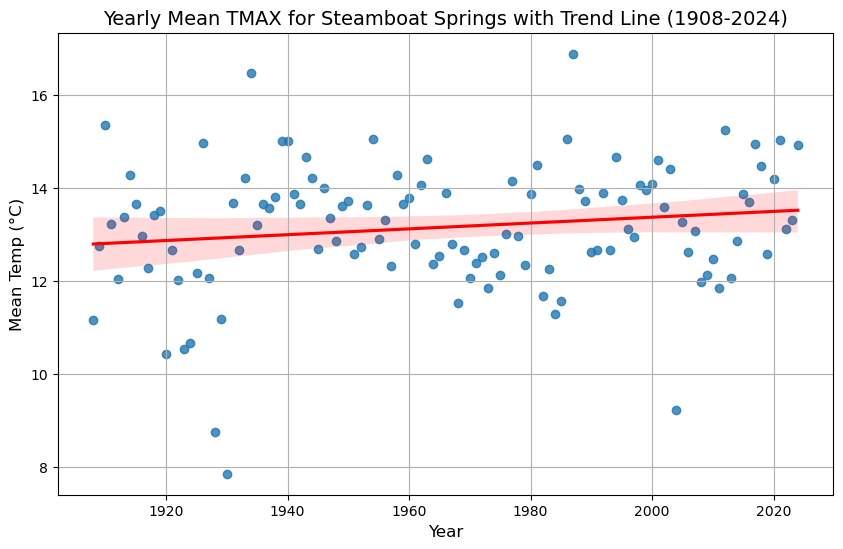

In this example the OLS and Ridge show mean average temperature increases +0.0063 °C/year and Lasso shows +0.0062 °C/year

The condition number is large, 1.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.


Data source is U.S. Department of Commerce National Centers for Environmental Information
National Oceanic & Atmospheric Administration
National Environmental Satellite, Data, and Information Service
151 Patton Avenue, Asheville, North Carolina 28801
These data are quality controlled and may not be identical to the original observations.

The Global Historical Climatology Network - Daily (GHCN-Daily/GHCNd) dataset integrates daily climate observations from approximately 30 different data sources. Version 3 was released in September 2012 with the addition of data from two additional station networks. Changes to the processing system associated with the version 3 release also allowed for updates to occur 7 days a week rather than only on most weekdays. Version 3 contains station-based measurements from well over 90,000 land-based stations worldwide, about two thirds of which are for precipitation measurement only. Other meteorological elements include, but are not limited to, daily maximum and minimum temperature, temperature at the time of observation, snowfall and snow depth. Over 25,000 stations are regularly updated with observations from within roughly the last month. The dataset is also routinely reconstructed (usually every week) from its roughly 30 data sources to ensure that GHCNd is generally in sync with its growing list of constituent sources. During this process, quality assurance checks are applied to the full dataset. Where possible, GHCNd station data are also updated daily from a variety of data streams. Station values for each daily update also undergo a suite of quality checks.

Citation: Menne, Matthew J., Imke Durre, Bryant Korzeniewski, Shelley McNeill, Kristy Thomas, Xungang Yin, Steven Anthony, Ron Ray, Russell S. Vose, Byron E.Gleason, and Tamara G. Houston (2012): Global Historical Climatology Network - Daily (GHCN-Daily), Version 3. [indicate subset used]. NOAA National Climatic Data Center. doi:10.7289/V5D21VHZ [2024-09-24]

Source Code Follows


/tmp/ipykernel_23733/2479285422.py:27: DtypeWarning: Columns (28,30,32,34,36,38,40,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  steamboat_climate_df = pd.read_csv(SteamboatClimateURL,


Missing TMAX values: 368
Filtered Date range: 1908-09-02 00:00:00 to 2024-09-18 00:00:00


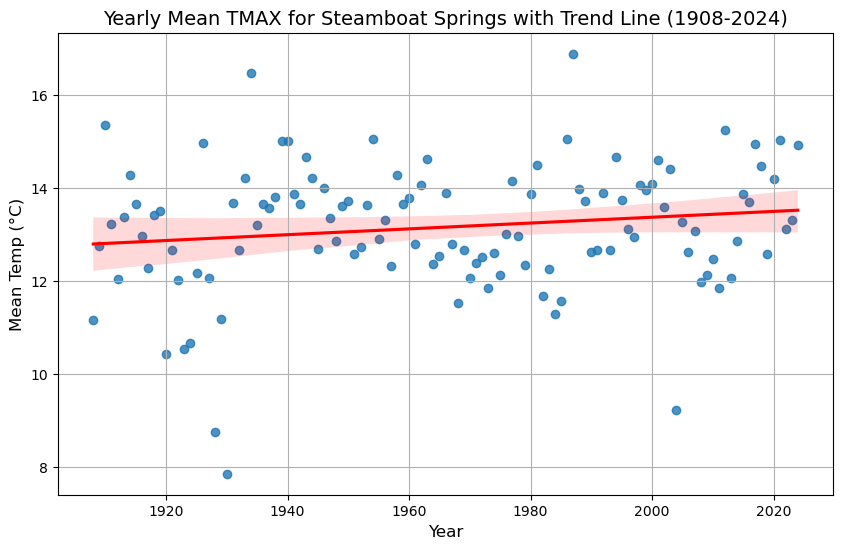

OLS Model Summary:
                            OLS Regression Results                            
Dep. Variable:                   TMAX   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.813
Date:                Fri, 27 Sep 2024   Prob (F-statistic):             0.0962
Time:                        20:33:05   Log-Likelihood:                -201.31
No. Observations:                 117   AIC:                             406.6
Df Residuals:                     115   BIC:                             412.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8482      7.341 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Having problems with code like this due to site timeout
# Read Global Historical Climatology Network daily (GHCNd) for the
# station with the largest dataset in Steamboat Springs, Colorado
# ran ok on 9/26, timing out on 9/27
# SteamboatTempURL = ('https://www.ncei.noaa.gov/access/services/data/v1?'
#    'dataset=daily-summaries'
#    '&dataTypes=TMAX'
#    '&dataTypes=TMIN'
#    '&stations=USC00057936'
#    '&startDate=1893-02-01'
#    '&endDate=2024-09-25'
#    '&units=metric')
# Google Drive file ID downloaded on 2024-09-19
file_id = '1tXD2YGxhEwXQ83UDxvad_co0fUc4Dn9m'

# Create a URL for direct download
SteamboatClimateURL = f'https://drive.google.com/uc?id={file_id}'

# Read the data from the CSV file
steamboat_climate_df = pd.read_csv(SteamboatClimateURL,
                                   index_col='DATE', 
                                   parse_dates=True, 
                                   na_values=['NaN'])

# Ensure that the index is properly converted to DatetimeIndex
steamboat_climate_df.index = pd.to_datetime(steamboat_climate_df.index, errors='coerce')

# Filter the data to only include rows from September 1908 onwards as before then 
# appears to have problems from 1893 to 1898 then no data till 1908
start_date = '1908-09-01'
steamboat_climate_df = steamboat_climate_df[steamboat_climate_df.index >= start_date]

# Check for missing data in TMAX
print("Missing TMAX values:", steamboat_climate_df['TMAX'].isna().sum())

# Drop rows where TMAX is NaN to avoid issues with plotting
steamboat_climate_df = steamboat_climate_df.dropna(subset=['TMAX'])

# Check the date range of the data to ensure it continues past 1908
print("Filtered Date range:", steamboat_climate_df.index.min(), "to", steamboat_climate_df.index.max())

# Resample data to yearly frequency and calculate the mean for TMAX
steamboat_yearly_mean_df = steamboat_climate_df['TMAX'].resample('YS').mean()

# Remove rows with missing or infinite values
steamboat_yearly_mean_df = steamboat_yearly_mean_df.replace([np.inf, -np.inf], np.nan).dropna()

# Create a 'Year' column from the index for regression
steamboat_yearly_mean_df = steamboat_yearly_mean_df.reset_index()
steamboat_yearly_mean_df['Year'] = steamboat_yearly_mean_df['DATE'].dt.year

# Plot the yearly mean TMAX with a trend line
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='Year', y='TMAX', data=steamboat_yearly_mean_df, line_kws={'color': 'red'})
plt.title('Yearly Mean TMAX for Steamboat Springs with Trend Line (1908-2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Temp (°C)', fontsize=12)
plt.grid(True)
plt.show()

# Prepare data for OLS Regression
X = steamboat_yearly_mean_df[['Year']]  # Predictor variable (Year)
y = steamboat_yearly_mean_df['TMAX']  # Response variable (Temperature)

# Add a constant (intercept term) to the predictor
X_ols = sm.add_constant(X)

# Fit the OLS model
model_ols = sm.OLS(y, X_ols).fit()

# Print the OLS model summary
print("OLS Model Summary:")
print(model_ols.summary())

# Extract the slope and intercept for OLS
slope_ols = model_ols.params['Year']
intercept_ols = model_ols.params['const']
print(f"Slope (OLS): {slope_ols:.4f} °C/year")
print(f"Intercept (OLS): {intercept_ols:.4f} °C")

# Consider using Ridge Regression
ridge_model = Ridge(alpha=1.0)  # You can adjust alpha to control the regularization strength
ridge_model.fit(X, y)

# Print Ridge model parameters
print("\nRidge Regression Coefficients:")
print(f"Slope (Ridge): {ridge_model.coef_[0]:.4f} °C/year")
print(f"Intercept (Ridge): {ridge_model.intercept_:.4f} °C")

# Consider using Lasso Regression
lasso_model = Lasso(alpha=0.1)  # You can adjust alpha to control the regularization strength
lasso_model.fit(X, y)

# Print Lasso model parameters
print("\nLasso Regression Coefficients:")
print(f"Slope (Lasso): {lasso_model.coef_[0]:.4f} °C/year")
print(f"Intercept (Lasso): {lasso_model.intercept_:.4f} °C")
